## Import packages

In [151]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

### load images from file

In [152]:
# function to laad images from a folder structure "datasets/s1/*.pgm"
def load_images(path):
    images = []
    labels = []
    if "non" in path:
        for i, dir in enumerate(os.listdir(path)):
            for file in os.listdir(os.path.join(path, dir)):
                img = Image.open(os.path.join(path, dir, file)).convert('L')
                img = img.resize((92,112))
                images.append(np.array(img).flatten())
                labels.append(i+1)
    else:
        for i, dir in enumerate(os.listdir(path)):
            for file in os.listdir(os.path.join(path, dir)):
                img = Image.open(os.path.join(path, dir, file))
                images.append(np.array(img).flatten())
                labels.append(i+1)
    return np.array(images), np.array(labels).reshape(-1,1)
faces,labels = load_images('datasets')
non_faces, non_labels = load_images('nonfaces_dataset')
print(faces.shape, labels.shape)
print(non_faces.shape, non_labels.shape)


(400, 10304) (400, 1)
(400, 10304) (400, 1)


## Suffle the images and labels

In [153]:
def shuffle_data(data, labels):
    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)
    return data[idx], labels[idx]

faces, labels = shuffle_data(faces, labels)
non_faces, non_labels = shuffle_data(non_faces, non_labels)

## Plot the data

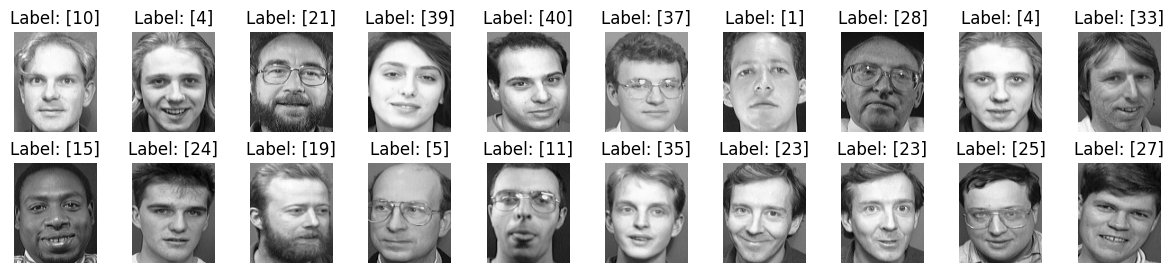

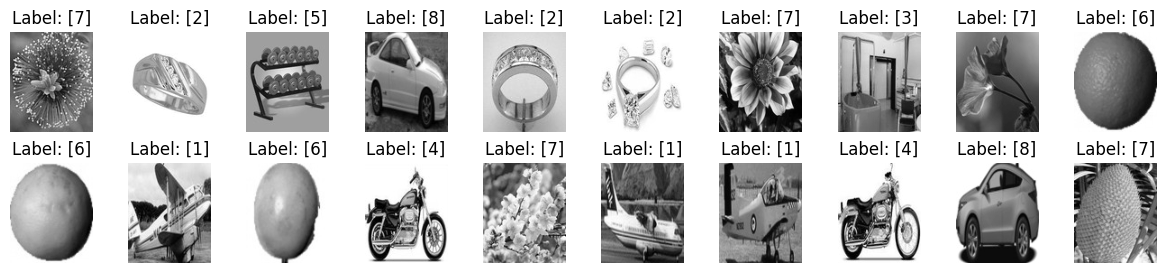

In [154]:
def plot_data(faces, labels, n=100):
    num_rows = n // 10
    fig, axs = plt.subplots(num_rows, 10, figsize=(15, 1.5 * num_rows), gridspec_kw={'hspace': 0.3})
    axs = axs.ravel()
    for i in range(n):
        axs[i].imshow(faces[i].reshape((112, 92)), cmap="gray")
        axs[i].set_title(f"Label: {labels[i]}")
        axs[i].axis("off")
    plt.show()

plot_data(faces, labels,20)
plot_data(non_faces, non_labels,20)

## split the dataset into training and testing

In [155]:

# function to split the data into training and testing which alpha is the percentage of the training data
def split_data(faces, faces_labels, non_faces,non_faces_labels,non_faces_count,alpha,non_face_precentage_in_train=1):
    if alpha == 0.5:
        faces_train = faces[::2]
        faces_train_labels = faces_labels[::2]
        faces_test = faces[1::2]
        faces_test_labels = faces_labels[1::2]

        non_faces_train = non_faces[:int(non_faces_count*non_face_precentage_in_train):2]
        non_faces_train_labels = non_faces_labels[:int(non_faces_count*non_face_precentage_in_train):2]

        non_faces_test = non_faces[1:non_faces_count:2]
        non_faces_test_labels = non_faces_labels[1:non_faces_count:2]
    else:
        n = len(faces)
        n_train = int(n*alpha)
        n_test = n - n_train
        idx = np.random.permutation(n)
        train_idx = idx[:n_train]
        test_idx = idx[n_train:]
        faces_train = faces[train_idx]
        faces_train_labels = faces_labels[train_idx]
        faces_test = faces[test_idx]
        faces_test_labels = faces_labels[test_idx]

        n = non_faces_count
        n_train = int(n*alpha)
        n_test = n - n_train
        idx = np.random.permutation(n)
        train_idx = idx[:n_train]
        test_idx = idx[n_train:]
        non_faces_train = non_faces[train_idx]
        non_faces_train_labels = non_faces_labels[train_idx]
        non_faces_test = non_faces[test_idx]
        non_faces_test_labels = non_faces_labels[test_idx]
    
    return np.append(faces_train, non_faces_train, axis=0), np.append(faces_train_labels, non_faces_train_labels, axis=0), np.append(faces_test, non_faces_test, axis=0), np.append(faces_test_labels, non_faces_test_labels, axis=0)


In [156]:
faces_labels = np.ones((len(faces),1))
non_faces_labels = np.zeros((len(non_faces),1))
train_data, train_labels, test_data, test_labels = split_data(faces, faces_labels, non_faces, non_faces_labels,400 , 0.5, 1)
print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

(400, 10304) (400, 1) (400, 10304) (400, 1)


# display samples of training data and test data

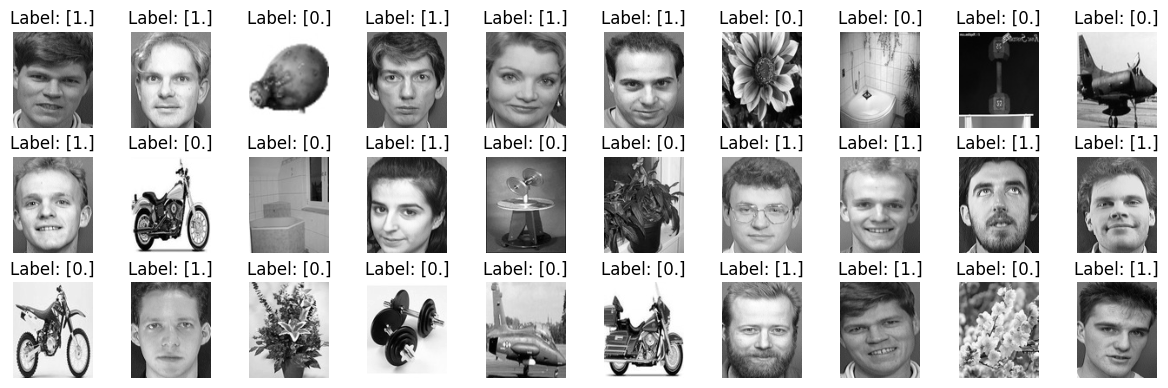

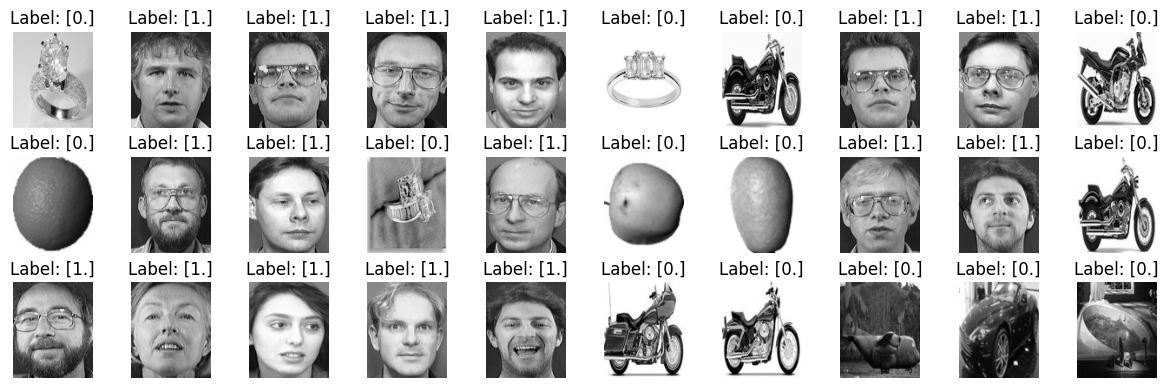

In [157]:
train_data, train_labels = shuffle_data( train_data,train_labels)
test_data, test_labels = shuffle_data( test_data,  test_labels)

plot_data(train_data, train_labels,30)
plot_data(test_data, test_labels,30)

## PCA imlementation

In [158]:
def PCA(train_data,alpha=0.95):
    mean = np.mean(train_data, axis=0)
    centered_data = train_data - mean
    
    cov_matrix = np.dot(centered_data,centered_data.T)
    print(cov_matrix.shape)
    # cov_matrix = np.cov(centered_data,rowvar=False,bias=True)
    eig_values, eig_vectors = np.linalg.eigh(cov_matrix)

    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]

    eig_vectors = np.dot(centered_data.T,eig_vectors)

    for i in range(eig_vectors.shape[1]):
        eig_vectors[:,i] = eig_vectors[:,i]/np.linalg.norm(eig_vectors[:,i])

    print(eig_vectors.shape)

    total = np.sum(eig_values)
    print("sum of eign values",total)
    var = 0
    k = 0
    while var/total < alpha:
        var += eig_values[k]
        k += 1
    print(f"Using {k} components to retain {alpha*100}% of the variance")
    return eig_vectors[:,:k], mean

space,mean= PCA(train_data,0.85)


(400, 400)
(10304, 400)
sum of eign values 17725071368.237507
Using 46 components to retain 85.0% of the variance


# Plot the eign faces

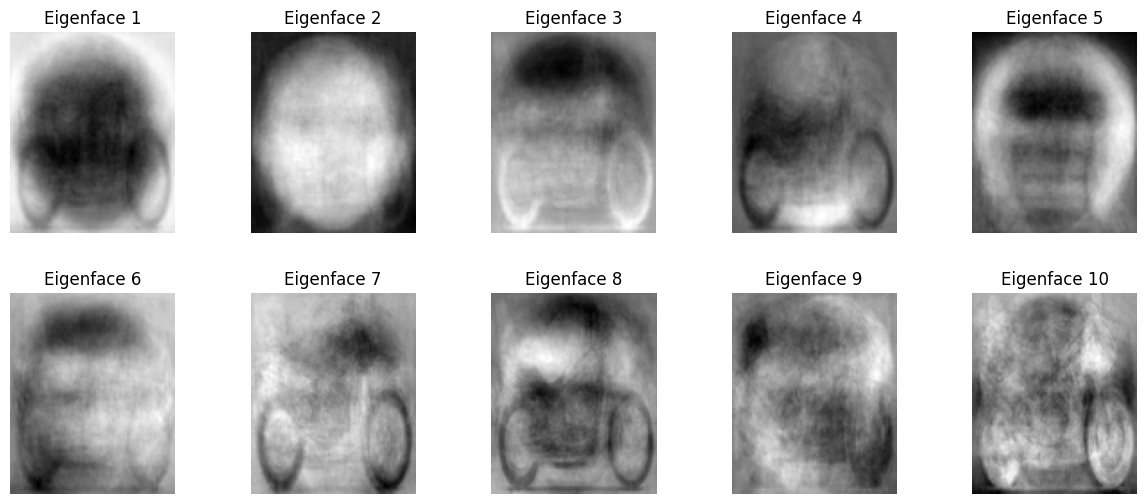

In [159]:
def plot_eigenfaces(eigenvectors, n=10):
    num_rows = n // 5
    _, axs = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows), gridspec_kw={'hspace': 0.3})
    axs = axs.ravel()
    for i in range(n):
        axs[i].imshow(eigenvectors[:, i].reshape((112, 92)), cmap="gray")
        axs[i].set_title(f"Eigenface {i+1}")
        axs[i].axis("off")
    plt.show()
plot_eigenfaces(space, 10)

## Project the data

In [160]:
def project_data(data, eigenvectors, mean,):
    return np.dot(data - mean, eigenvectors)
train_projected = project_data(train_data, space, mean)
test_projected = project_data(test_data, space, mean)

## Classification and show the accuracy

In [161]:
def knn_classifier(train_data, train_labels, test_data, test_labels, k=1):
    knn = KNeighborsClassifier( n_neighbors=1 )
    knn.fit( train_data, train_labels.ravel() )
    # Testing the model and calculating the accuracy
    return accuracy_score(test_labels, knn.predict(test_data).ravel()), knn.predict(test_data).ravel()

print("Accuracy of KNN classifier with k=1:", knn_classifier(train_projected, train_labels, test_projected, test_labels, 1)[0])

Accuracy of KNN classifier with k=1: 0.9675


## Show failure and success cases.

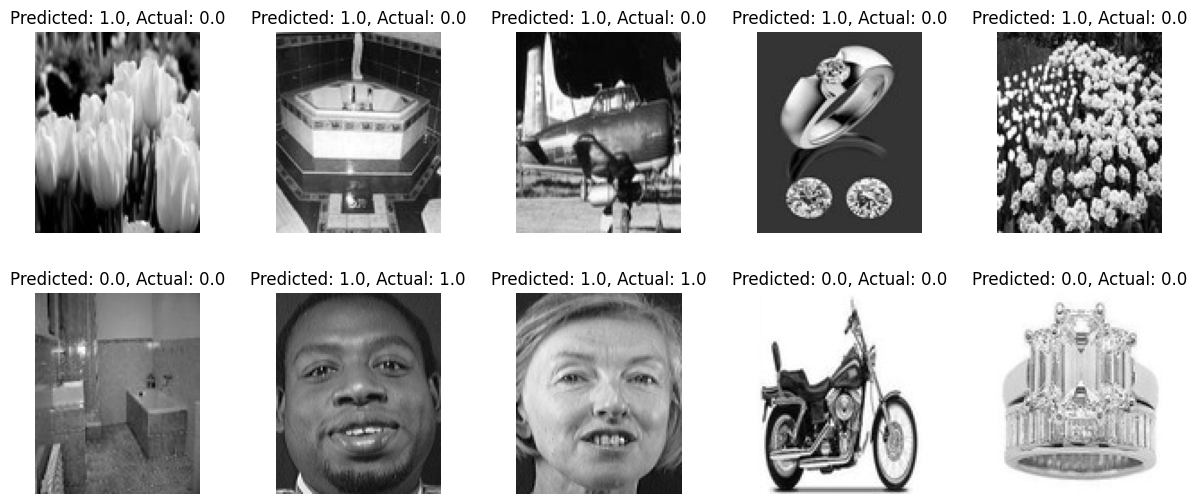

In [168]:
def plot_failure_and_success(data, labels, predictions, n=10):
    failure_idx = np.where(predictions != labels)[1]
    success_idx = np.where(predictions == labels)[1]

    for i in range(len(labels)):
        if labels[0,i] != predictions[i]:
            print(f"Predicted: {predictions[i]}, Actual: {labels[0,i]}")


    num_rows = n // 5
    fig, axs = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows), gridspec_kw={'hspace': 0.3})
    axs = axs.ravel()
    for i in range(n):
        if i < n/2:
            axs[i].imshow(data[failure_idx[i]].reshape((112, 92)), cmap="gray")
            axs[i].set_title(f"Predicted: {predictions[failure_idx[i]]}, Actual: {labels[0,failure_idx[i]]}")
        else:
            axs[i].imshow(data[success_idx[i-len(failure_idx)]].reshape((112, 92)), cmap="gray")
            axs[i].set_title(f"Predicted: {predictions[success_idx[i-len(failure_idx)]]}, Actual: {labels[0,success_idx[i-len(failure_idx)]]}")
        axs[i].axis("off")
    plt.show()

plot_failure_and_success(test_data, test_labels.reshape(1,-1), knn_classifier(train_projected, train_labels, test_projected, test_labels, 1)[1], 10)    